### Online store

Today we will analyze online sales data to understand market and customer trends. We work for an imaginary online store in the US. The goal is to extract insights from the dataset online_sales in order to give recommendations to the company on new effective marketing campaigns.


Load the dataset, understand the data, make visualizations, clean the data (think which transactions are counted as valid to your project) and make all the necessary data transformation and aggregations to answer the following questions (communicate your results with visualizations):

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.precision', 2)

In [2]:
df = pd.read_csv('csv/online_sales.csv')

/tmp/ipykernel_159473/2166572984.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('csv/online_sales.csv')


I got a warning in the first column which I am curious to inspect

In [3]:
df.iloc[:5,0]

0    100354678
1    100354678
2    100354680
3    100354680
4    100367357
Name: order_id, dtype: object

it is an `order_id` column and it seems to be numeric. I am going to examine if there are any values that don't adhere to a strictly numeric pattern. To achieve this I am going to use regex

In [4]:
sample = pd.read_csv('csv/online_sales.csv', usecols=[0], dtype=str)
non_numeric = sample[~sample.iloc[:, 0].str.match(r'^\d+$', na=False)]
print(non_numeric.head())

           order_id
206148  100468520-1
272777  100542843-1
275274  100546199-1
275275  100546199-1
277993  100549449-1


As we can see, some of them have a non-numeric format which is ok, because I want my order_id to be strings (objects).  
I will be loading that particular column as a string

In [5]:
df = pd.read_csv('csv/online_sales.csv', dtype={'order_id': str})

Now I will inspect the columns for types and null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286392 entries, 0 to 286391
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          286392 non-null  object 
 1   order_date        286392 non-null  object 
 2   status            286392 non-null  object 
 3   item_id           286392 non-null  float64
 4   sku               286392 non-null  object 
 5   qty_ordered       286392 non-null  float64
 6   price             286392 non-null  float64
 7   value             286392 non-null  float64
 8   discount_amount   286392 non-null  float64
 9   total             286392 non-null  float64
 10  category          286392 non-null  object 
 11  payment_method    286392 non-null  object 
 12  bi_st             286392 non-null  object 
 13  cust_id           286392 non-null  float64
 14  year              286392 non-null  int64  
 15  month             286392 non-null  object 
 16  ref_num           28

In [7]:
df.isna().sum().sum()  # just to verify

0

by looking at the column names, it seems like a typical denormalized sales dataset, probably a result of join of a sales table, a customer table and an item table (inventory table entries do not seem to be present here).

##### Which category gives the highest sales?

In [8]:
total_sales_per_category = df.groupby('category')['total'].sum()
total_sales_per_category  / 10_000

category
Appliances             3006.08
Beauty & Grooming       264.47
Books                     3.24
Computing               936.23
Entertainment          2713.84
Health & Sports         102.00
Home & Living           181.06
Kids & Baby              85.62
Men's Fashion           482.01
Mobiles & Tablets     13011.20
Others                 1556.43
School & Education       11.47
Soghaat                  57.67
Superstore              288.69
Women's Fashion         664.98
Name: total, dtype: float64

In [9]:
total_sales_per_category.idxmax()

'Mobiles & Tablets'

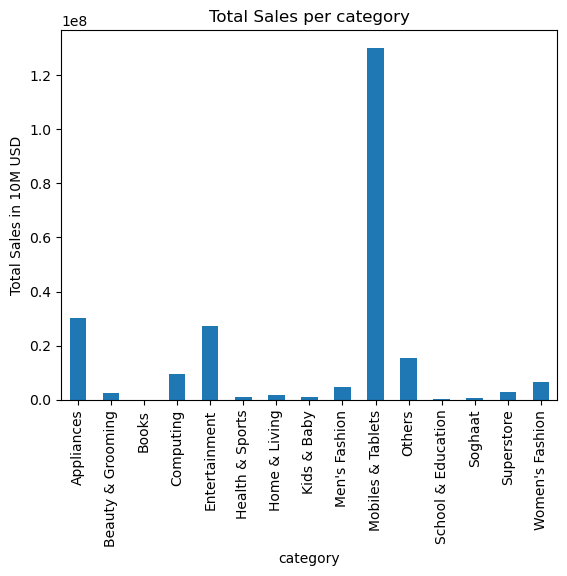

In [10]:
total_sales_per_category.plot(kind='bar', title='Total Sales per category')
plt.ylabel('Total Sales in 10M USD')
plt.show()

##### Which categories are bought the most from men and which from women?

To answer this I will only look at the count of orders for each category, without taking into acount the quantity of each purchase. The reason for doing this, is the fact that cheaper items like book are far more likely to show multiple items per order, and that would lead to bias towards such items.

In [11]:
categories_per_gender = pd.crosstab(df['category'], df['Gender'])
categories_per_gender

Gender,F,M
category,,
Appliances,16586,16448
Beauty & Grooming,8959,8940
Books,377,437
Computing,3888,4222
Entertainment,8676,8676
Health & Sports,2872,5549
Home & Living,7014,6976
Kids & Baby,3306,3186
Men's Fashion,20150,20563


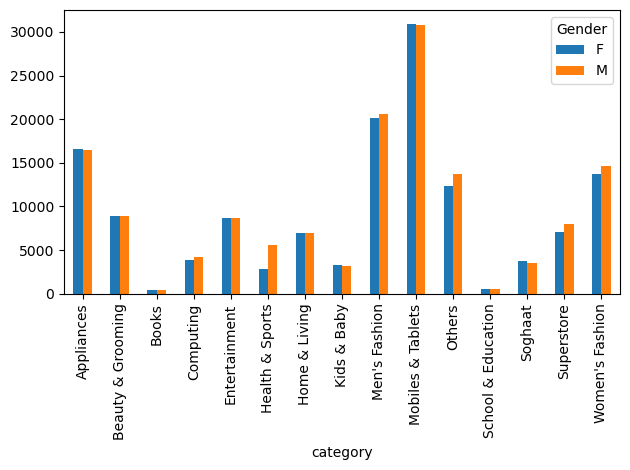

In [12]:
categories_per_gender.plot(kind='bar')
plt.tight_layout()
plt.show()

##### Which month of the year has the highest revenue? Can you guess why?  

We need to retrieve the month of the order first, as the month field contains month and year combined. I first need to convert order_date to datetime and then create a column called order_month

In [23]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.month
total_per_month = df.groupby('order_month')['total'].sum()
total_per_month.idxmax()

12

December is the highest revenue month and it makes a lot of sense considering the Christmas holidays. Let's see it in a bar chart too.

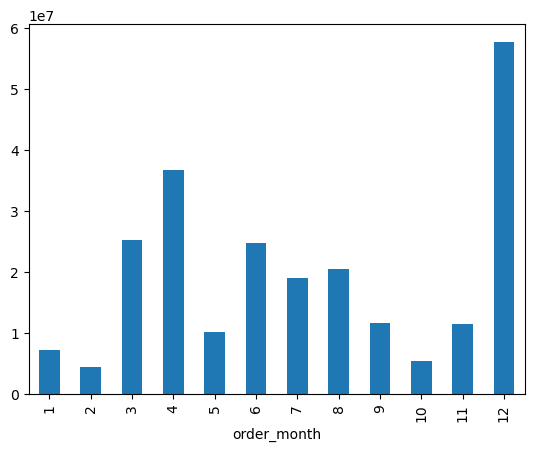

In [25]:
total_per_month.plot(kind='bar')
plt.show()

##### Which are the top five states that generate the highest revenue?  

In [29]:
top_five_states_revenue = df.groupby('State')['total'].sum().sort_values().tail(5)[::-1]
top_five_states_revenue

State
TX    1.55e+07
CA    1.39e+07
NY    1.14e+07
PA    1.02e+07
IL    9.11e+06
Name: total, dtype: float64

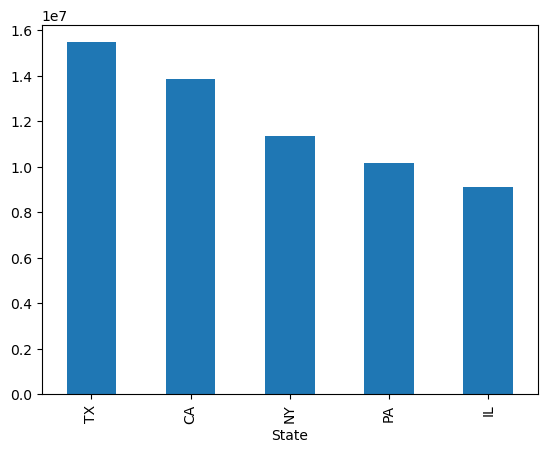

In [30]:
top_five_states_revenue.plot(kind='bar')
plt.show()

##### Which category is the highest in terms of revenue for each state? (Hard!)  

In [45]:
category_state_sales = pd.pivot_table(data=df, values='total', columns='State', index='category', aggfunc='sum')
category_state_sales

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
category,,,,,,,,,,,,,,,,,,,,,
Appliances,1.96e+05,5.40e+05,4.35e+05,3.71e+05,2.13e+06,4.67e+05,246366.51,161278.52,86660.12,1.34e+06,...,223750.34,5.08e+05,2.06e+06,243470.82,8.74e+05,1.94e+05,3.63e+05,5.22e+05,6.37e+05,185177.18
Beauty & Grooming,2.18e+04,4.61e+04,5.10e+04,4.12e+04,1.40e+05,5.33e+04,38403.68,15763.16,3853.25,9.70e+04,...,124444.42,3.64e+04,1.34e+05,29840.78,5.97e+04,2.37e+04,2.70e+04,3.99e+04,5.67e+04,17547.76
Books,9.49e+01,2.48e+02,1.53e+02,1.69e+02,4.15e+03,1.00e+03,221.15,3397.60,0.00,2.08e+03,...,226.00,3.58e+02,1.83e+03,70.90,1.29e+02,1.59e+02,4.04e+02,7.90e+01,6.80e+02,181.93
Computing,5.91e+04,2.16e+05,1.21e+05,2.28e+05,5.57e+05,1.86e+05,77392.71,134298.27,7267.00,4.03e+05,...,277592.06,1.14e+05,4.35e+05,154332.55,4.18e+05,2.51e+05,5.90e+04,2.20e+05,1.65e+05,19757.53
Entertainment,3.13e+05,4.66e+05,2.97e+05,3.20e+05,2.03e+06,4.67e+05,268934.22,146394.10,59684.35,1.17e+06,...,184994.89,5.59e+05,1.70e+06,368251.49,1.27e+06,1.35e+05,4.92e+05,5.39e+05,6.15e+05,154926.65
Health & Sports,4.19e+03,1.92e+04,1.46e+04,1.05e+04,3.28e+04,1.52e+04,8777.18,7600.97,1747.70,4.04e+04,...,9588.55,1.20e+04,7.11e+04,3629.84,5.38e+04,5.45e+03,9.89e+03,2.20e+04,2.67e+04,20243.95
Home & Living,1.79e+04,4.47e+04,3.19e+04,1.23e+04,1.42e+05,2.40e+04,20548.90,8687.94,1550.80,4.00e+04,...,13957.76,1.39e+04,1.04e+05,8642.66,6.51e+04,1.88e+04,2.74e+04,5.16e+04,3.14e+04,27078.46
Kids & Baby,6.27e+03,7.38e+03,8.42e+03,6.39e+03,6.55e+04,1.08e+04,15080.10,2430.66,3811.53,2.66e+04,...,17077.04,2.19e+04,5.15e+04,7422.81,2.81e+04,4.15e+03,9.49e+03,1.94e+04,1.38e+04,1383.09
Men's Fashion,4.22e+04,8.88e+04,7.33e+04,6.19e+04,2.92e+05,9.36e+04,54370.69,22831.71,8728.78,2.31e+05,...,40046.29,6.96e+04,3.25e+05,39885.41,1.24e+05,3.99e+04,5.72e+04,1.04e+05,7.95e+04,27448.79


In [46]:
for state in category_state_sales.columns:
    print(f'in {state}, the {category_state_sales[state].idxmax()} category has the highest sales')

in AK, the Mobiles & Tablets category has the highest sales
in AL, the Mobiles & Tablets category has the highest sales
in AR, the Mobiles & Tablets category has the highest sales
in AZ, the Mobiles & Tablets category has the highest sales
in CA, the Mobiles & Tablets category has the highest sales
in CO, the Mobiles & Tablets category has the highest sales
in CT, the Mobiles & Tablets category has the highest sales
in DC, the Mobiles & Tablets category has the highest sales
in DE, the Mobiles & Tablets category has the highest sales
in FL, the Mobiles & Tablets category has the highest sales
in GA, the Mobiles & Tablets category has the highest sales
in HI, the Mobiles & Tablets category has the highest sales
in IA, the Mobiles & Tablets category has the highest sales
in ID, the Mobiles & Tablets category has the highest sales
in IL, the Mobiles & Tablets category has the highest sales
in IN, the Mobiles & Tablets category has the highest sales
in KS, the Mobiles & Tablets category ha

##### Which category gives discounts more often? Visualize the top 5 of them.  

In [47]:
df['discount_amount'].sample(20)

216294      0.00
190793      0.00
11293       0.00
230346      0.00
180329      0.00
110956      0.00
208593    284.50
281825     40.00
177181      0.00
91544      50.00
13077       0.00
130186      0.00
156542      0.00
51067       1.32
122363     19.24
61484       0.00
20973       0.00
130688      0.00
18579      17.60
232025      0.00
Name: discount_amount, dtype: float64

In order to tackle this, simply counting the discounted orders is not enough because some have a much higher number of orders than other. Instead I want to calculate a ratio of discounted orders over the total orders for each category. To do this I need to first create a boolean category that will indicate if an order was discounted.

In [61]:
df['is_discounted'] = df['discount_amount'].map(bool)
df.sample(100000)

,order_id,order_date,status,item_id,sku,qty_ordered,price,value,discount_amount,total,...,City,State,Zip,Region,User Name,Discount_Percent,age_group,order_month,is_discounted,category_count
140932,100416760,2020-12-27,canceled,679593.0,MATHUA59B7EB40CD5BF,2.0,1242.3,1242.3,186.34,1055.95,...,Utica,NY,13503,Northeast,camancuso,15.00,18-24,12,True,61761
31270,100360447,2020-10-30,complete,584814.0,MEFCUR59B7AA3234368,11.0,189.9,1899.0,0.00,1899.00,...,Westwood,NJ,7675,Northeast,orcordova,0.00,45-54,10,False,40713
285420,100560899,2021-09-20,received,902500.0,WOFDEA5B1ED8BDD0D5C,2.0,69.9,69.9,0.00,69.90,...,Miquon,PA,19452,Northeast,nkkania,0.00,45-54,9,False,28334
41238,100526557,2021-06-13,canceled,845948.0,KABSTI5AABA4A139BE3,11.0,8.9,89.0,0.00,89.00,...,Rockaway Beach,OR,97136,West,eklabelle,0.00,45-54,6,False,6492
193904,100457455,2021-03-23,canceled,751649.0,MATSAM5A7D904F75A49,1.0,1716.0,0.0,0.00,0.00,...,Powellton,WV,25161,South,eqsegal,6.99,25-34,3,False,61761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,100357403,2020-10-15,complete,579744.0,BAGCRE59AD164FB1389,2.0,60.0,60.0,0.00,60.00,...,Tallmansville,WV,26237,South,dumcclendon,0.00,25-34,10,False,17899
270206,100542947,2021-07-21,received,872865.0,WOFFAS5AD50898C3126,2.0,79.9,79.9,0.00,79.90,...,Orlando,FL,32834,South,addunavant,0.00,25-34,7,False,28334
177751,100543360,2021-07-23,order_refunded,873461.0,HASQAR5A618CB18BD17,2.0,10.6,10.6,0.00,10.60,...,Dekalb,IL,60115,Midwest,jugonzalez,0.00,45-54,7,False,8421
88290,100486477,2021-04-25,complete,793241.0,VIT5A9D40BDAFF51,11.0,73.5,735.0,147.00,588.00,...,Alva,WY,82711,West,jdstorms,20.00,45-54,4,True,15024


Below we can see in percentages, the percentage of orders its category discounts

In [62]:
discount_prc_category = df.groupby('category').apply(lambda group: sum(group['is_discounted']) / len(group)) * 100
discount_prc_category

category
Appliances            46.61
Beauty & Grooming     22.43
Books                  4.30
Computing             41.31
Entertainment         57.58
Health & Sports       13.10
Home & Living         21.47
Kids & Baby           15.93
Men's Fashion         17.49
Mobiles & Tablets     44.36
Others                 1.58
School & Education     8.81
Soghaat               16.55
Superstore            38.54
Women's Fashion       20.43
dtype: float64

And now we will plot the top 5 of them

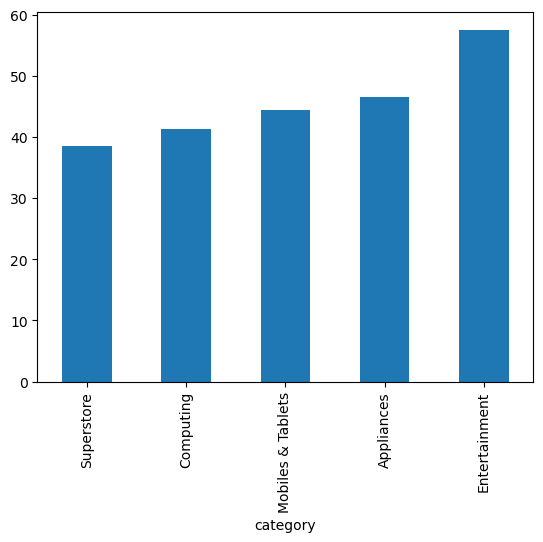

In [64]:
discount_prc_category.sort_values().tail(5).plot(kind='bar')
plt.show()

##### Which age segment spends the most?  

##### For the category with the highest revenue, plot the revenue per week for CA.  

##### What is the average item count per order in each category?  

##### Which two days of the week have the highest number of transactions?  

##### If you wanted to launch an effective marketing campaign, in which category, age, gender, time of the year and days of the week would be to maximize its efficiency? Are you considering offering products at a discount and why?